# Combined Data Analysis 

In [1]:
import pandas as pd

# Read in the merged CSV file
df = pd.read_csv('../data/ais_rfv_long.csv')

# Optional: View the shape and a preview of the data
print(df.shape)
print(df.head())


(2298, 10)
  flag     vessel_name         mmsi        imo  fishing_hours   fishing_area  \
0  CHN    DONG YU 1521  412421095.0        NaN          22.86           hsp7   
1  CHN    DONG YU 1521  412421095.0        NaN         291.10           hsp6   
2  CHN    DONG YU 1521  412421095.0        NaN        1421.71   kirbati2_eez   
3  CHN    DONG YU 1521  412421095.0        NaN         741.84  kiribati1_eez   
4  CHN  FENG XIANG 818  412439604.0  8996176.0          12.19      nauru_eez   

                                     owner   vessel_type      owner_location  \
0  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner  ('Zhoushan', None)   
1  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner  ('Zhoushan', None)   
2  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner  ('Zhoushan', None)   
3  Zhejiang Xingpeng Ocean Fishery CO.,LTD     Longliner  ('Zhoushan', None)   
4    Ningbo Yongfa Ocean Fisheries CO.,LTD  Purse seiner   ('NINGBO', 'CHN')   

             home_port  
0 

## Network Analysis Options

### Vessel–Vessel via Shared Fishing Area
- **Nodes**: Individual vessels
- **Edges**: An edge is created between vessels that have fished in the same area.
- **Edge Weight**: Could reflect the number of shared fishing areas or the sum of fishing hours in those shared zones.
- **Uses**: Identify operational clusters or coordination patterns between vessels.

### Vessel–Owner Bipartite Network
- **Nodes**: Vessels and their owners
- **Edges**: Represent the ownership relationship.
- **Projected Network**: You can create a vessel–vessel co-ownership network by projecting the bipartite graph.
- **Uses**: Analyze corporate structure, ownership concentration, and influence.

### Vessel–Port Network
- **Nodes**: Vessels and their home ports (or owner locations)
- **Edges**: Represent home port assignments.
- **Edge Weight**: Optional — total fishing hours associated with each port.
- **Uses**: Analyze centrality of key ports and their importance in regional operations.

### Vessel–Fishing Area Network
- **Nodes**: Vessels and fishing areas
- **Edges**: Represent activity in a given area.
- **Edge Weight**: Total hours spent fishing in that area.
- **Projected Network**: Vessel–vessel or area–area projections based on co-participation.
- **Uses**: Understand spatial patterns of fishing effort.

### Owner–Fishing Area Network
- **Nodes**: Owners and fishing areas
- **Edges**: Represent where their vessels operate.
- **Edge Weight**: Aggregate fishing hours across all vessels per owner per area.
- **Uses**: Identify regional dominance of certain owners and their operational reach.


# 1: Vessel to Vessel via Shared Fishing Area 

In [2]:
import networkx as nx
from itertools import combinations

# Group vessels by fishing area
area_groups = df.groupby('fishing_area')['vessel_name'].unique()

# Build edges between vessels that shared a fishing area
G1 = nx.Graph()
for vessels in area_groups:
    for v1, v2 in combinations(vessels, 2):
        if G1.has_edge(v1, v2):
            G1[v1][v2]['weight'] += 1
        else:
            G1.add_edge(v1, v2, weight=1)

print(f"Vessel–Vessel Graph: {G1.number_of_nodes()} nodes, {G1.number_of_edges()} edges")


Vessel–Vessel Graph: 875 nodes, 126542 edges


# 2: Vessel to Owner Bipartite Network; Projected Vessel–Vessel Network

In [3]:
from networkx.algorithms import bipartite

# Create bipartite graph: vessels and owners
B = nx.Graph()
vessels = df['vessel_name'].unique()
owners = df['owner'].unique()

B.add_nodes_from(vessels, bipartite='vessels')
B.add_nodes_from(owners, bipartite='owners')

# Add edges (ownership relations)
for _, row in df[['vessel_name', 'owner']].dropna().drop_duplicates().iterrows():
    B.add_edge(row['vessel_name'], row['owner'])

# Project to vessel–vessel network (shared ownership)
G2 = bipartite.weighted_projected_graph(B, vessels)

print(f"Vessel–Vessel Co-ownership Graph: {G2.number_of_nodes()} nodes, {G2.number_of_edges()} edges")


Vessel–Vessel Co-ownership Graph: 875 nodes, 1204 edges


# 3 Vessel to Port Network (Using Home Port, which is the registered value)

In [4]:
# Clean up ports
df['home_port_clean'] = df['home_port'].astype(str).str.replace('[()\'\"]', '', regex=True)

# Build bipartite graph: vessels and home ports
G3 = nx.Graph()
vessels = df['vessel_name'].unique()
ports = df['home_port_clean'].unique()

G3.add_nodes_from(vessels, bipartite='vessels')
G3.add_nodes_from(ports, bipartite='ports')

# Add edges
for _, row in df[['vessel_name', 'home_port_clean']].dropna().drop_duplicates().iterrows():
    G3.add_edge(row['vessel_name'], row['home_port_clean'])

print(f"Vessel–Port Graph: {G3.number_of_nodes()} nodes, {G3.number_of_edges()} edges")


Vessel–Port Graph: 957 nodes, 882 edges


## updated nx_tools.py to contain an analyze_network function


Analysis for Vessel–Vessel (Fishing Area)
Top nodes by betweenness centrality:
  ZHONGSHUI 917: 0.0101
  YI MAN NO.8: 0.0101
  ZHONGSHUI 927: 0.0100
  DE CHAN NO.26: 0.0085
  JIN FONG SHUUN: 0.0074
  MAN YING CAI NO.6: 0.0074
  CHIEN YUAN MING: 0.0072
  YI RONG NO3: 0.0069
  LIAOYUANYU101: 0.0068
  SHUN RONG NO.268: 0.0064
Detected 3 communities


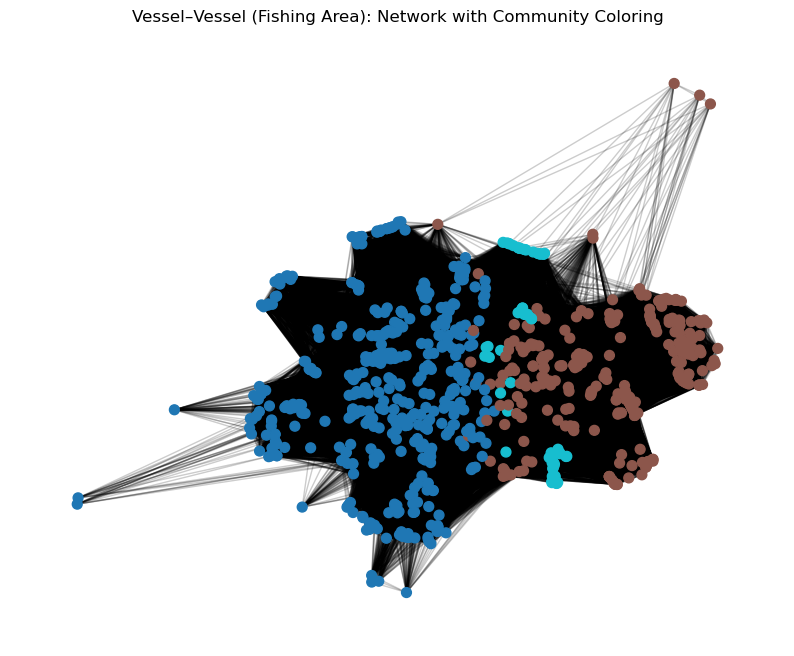

In [5]:
from nx_tools import analyze_network

results1 = analyze_network(G1, graph_name="Vessel–Vessel (Fishing Area)")

## Examining Community Characterization

In [8]:
import pandas as pd
import networkx as nx

def summarize_communities(G, df, id_col='vessel_name'):
    """
    Summarize properties of each community in the vessel network.

    Parameters:
    - G: networkx.Graph with "community" node attributes
    - df: DataFrame containing vessel metadata
    - id_col: Column in df that matches G nodes (e.g., 'vessel_name')

    Returns:
    - community_df: DataFrame summarizing each community
    """
    comm_map = nx.get_node_attributes(G, "community")
    df = df.copy()
    
    # Attach community labels
    df["community"] = df[id_col].map(comm_map)

    # Drop rows without community assignment (non-connected nodes)
    df = df.dropna(subset=["community"])

    # Group and summarize
    grouped = df.groupby("community").agg(
        num_vessels = (id_col, "nunique"),
        total_fishing_hours = ("fishing_hours", "sum"),
        num_unique_flags = ("flag", pd.Series.nunique),
        num_unique_owners = ("owner", pd.Series.nunique),
        num_unique_areas = ("fishing_area", pd.Series.nunique),
        most_common_type = ("vessel_type", lambda x: x.mode().iloc[0] if not x.mode().empty else None),
        top_ports = ("home_port", lambda x: x.value_counts().head(3).to_dict())
    ).reset_index()

    return grouped

In [9]:
community_summary_df = summarize_communities(G1, df)
community_summary_df.head()


,community,num_vessels,total_fishing_hours,num_unique_flags,num_unique_owners,num_unique_areas,most_common_type,top_ports
0,0,476,860703.65,20,254,21,Longliner,"{'('Kaohsiung', None)': 252, '('Shidao', 'CHN'..."
1,1,329,369792.71,10,310,19,Tuna longliner,"{'('Kaohsiung', None)': 476, '('Zhoushan', 'CH..."
2,2,70,93405.22,9,50,13,Tuna longliner,"{'('Shekou', 'CHN')': 39, '('Kaohsiung', None)..."


## Vessel–Vessel Network Based on Shared Fishing Areas

### Network Description
This network represents vessels as nodes, where edges are formed between vessels that operate in the same fishing area. The edge weight reflects the number of shared fishing zones between pairs of vessels. This frame captures patterns of co-location and potential coordination in fishing operations. Though some areas of the plot are hard to discern, the color-coding of each edge begins to show the community relationships. 

### Betweenness Centrality Analysis
The vessels with the highest betweenness centrality are:

- ZHONGSHUI 917
- YI MAN NO.8
- ZHONGSHUI 927
- DE CHAN NO.26
- JIN FONG SHUUN
- MAN YING CAI NO.6
- CHIEN YUAN MING
- YI RONG NO3
- LIAOYUANYU101
- SHUN RONG NO.268

These vessels serve as bridges between clusters of vessels, facilitating indirect connectivity. Their high centrality suggests that they:

- Operate across multiple regions
- May be linked to diversified fleets or firms
- Could play key roles in transshipment, coordination, or surveillance contexts

These vessels warrant further investigation, particularly if one is assessing transboundary fishing behavior or network control points.

### Community Detection
The modularity-based algorithm identified **3 distinct communities** in the vessel network. This structure likely reflects:

- Regional fishing grounds (e.g., Kiribati EEZ vs. Nauru EEZ)
- Clusters of vessels operating under the same ownership or flag
- Operational sub-networks based on co-fishing behavior

The detected communities correspond visually to densely interconnected subgraphs, with relatively few links between them. This separation suggests strong within-group coordination and limited cross-group interaction.

### Visualization Summary
The network visualization illustrates:

- A densely connected core where vessels share multiple fishing areas
- Clear visual separation among the three detected communities
- A few vessels acting as connectors or “bridges” between clusters

This suggests that fishing efforts are structured and potentially coordinated within communities, with select vessels linking them together.


# Vessel to Vessel Shared Ownership


Analysis for Vessel–Vessel (Shared Ownership)
Top nodes by betweenness centrality:
  HONG YANG 9: 0.0000
  LU RONG YUAN YU 888: 0.0000
  LU RONG YUAN YU 889: 0.0000
  LURONGYUANYU205: 0.0000
  LURONGYUANYU206: 0.0000
  LURONGYUANYU207: 0.0000
  LURONGYUANYU208: 0.0000
  LURONGYUANYU209: 0.0000
  LURONGYUANYU210: 0.0000
  LURONGYUANYU798: 0.0000
Detected 580 communities


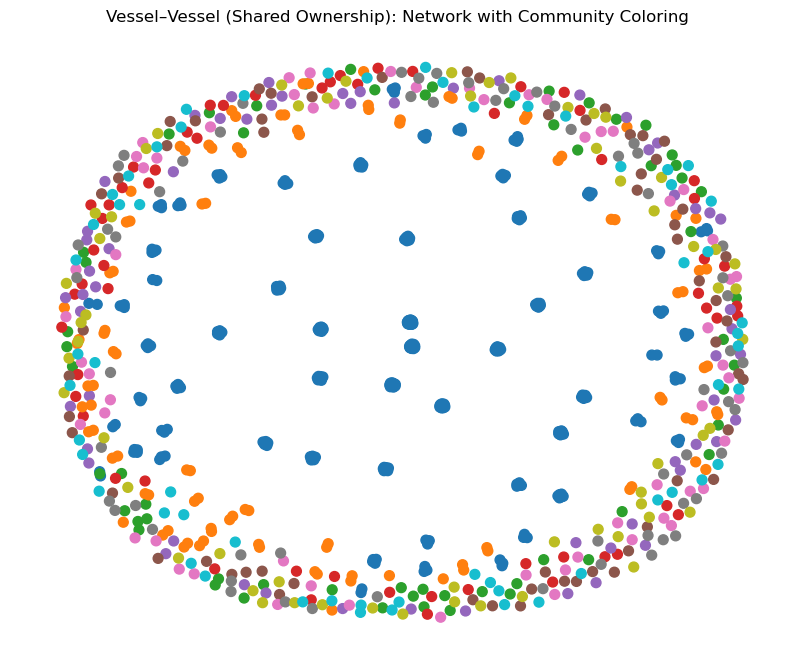

In [6]:
results2 = analyze_network(G2, graph_name="Vessel–Vessel (Shared Ownership)")

### Description
This network represents vessels as nodes, with edges indicating shared ownership. Specifically, an edge connects two vessels if they are owned by the same company. The resulting graph is a **projected bipartite graph** where original owner nodes have been removed, and connections reflect co-ownership.

### Betweenness Centrality Analysis
None of the vessels had high betweenness centrality in this network (all with scores of `0.0000`). 

This suggests that the network contains many (a ton) disconnected components or very low-connectivity clusters, where most vessels only link to a small, isolated subset. In this structure:
- There are few or no bridges between different ownership groups.
- The ownership structure is highly modular, with vessels tightly clustered within companies but not between them.
- There is no vessel acting as a central coordinator across owners.

### Community Detection
The algorithm detected 580 communities, which is nearly the same as the number of unique owners or vessel clusters. This indicates that each community likely corresponds to a distinct company or small ownership group. The network is extremely fragmented, confirming the sparse connectivity seen in the centrality scores. The uniform distribution of nodes arranged in a circular layout, with almost no visual overlap between communities, is visually consistent with the community detection outcome, reinforcing the interpretation of a highly modular, company-centric structure.

This network frame is ideal for analyzing fleet composition and ownership control, but less suited to identifying coordination across firms. From a community standpoint, this makes some sense, as the scale to coordinate many large (or even small) fishing vessels is extremely difficult. Having small clusters, even one or two operations, is the more likely outcome for this plot. 


# Vessel to Port (with Community Coloring)


Analysis for Vessel–Port
Top nodes by betweenness centrality:
  Kaohsiung, None: 0.1160
  Shidao, CHN: 0.0088
  Zhoushan, CHN: 0.0086
  Shekou, CHN: 0.0028
  Busan, None: 0.0027
  Yantai, CHN: 0.0015
  HONG YANG 8: 0.0014
  HONG YANG 88: 0.0014
  HONGYANG8: 0.0014
  HONGYANG88: 0.0014
Detected 79 communities


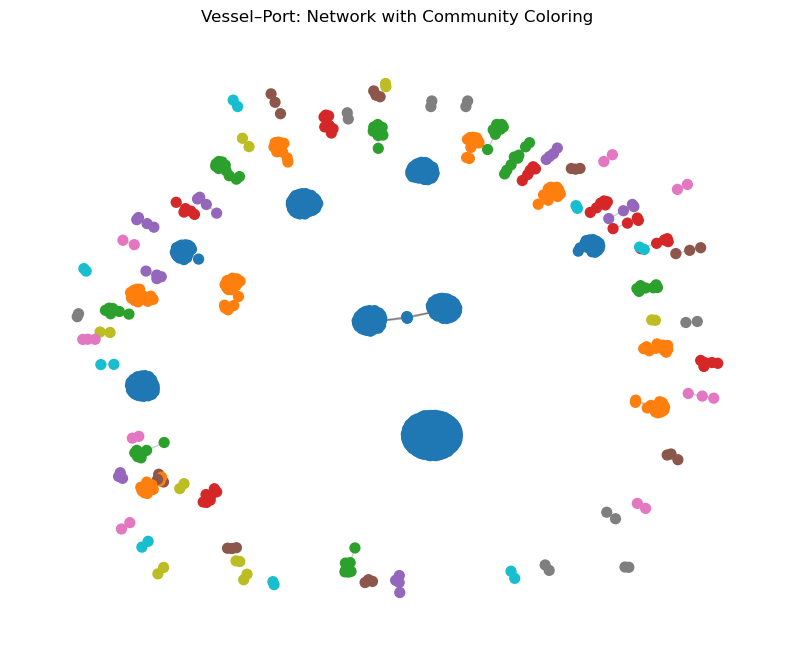

In [7]:
results3 = analyze_network(G3, graph_name="Vessel–Port")

### Network Description
This bipartite-style network connects vessels with their assigned home ports. Nodes represent either vessels or ports, and edges signify a home port assignment. The structure helps capture geographic dependencies, logistical hubs, and the localization of fleets.

### Betweenness Centrality Analysis
The nodes with the highest betweenness centrality include a mix of major ports and a small number of vessels that appear to link isolated subnetworks. Notably:

- **Kaohsiung, None**: 0.1160
- **Shidao, CHN**: 0.0088
- **Zhoushan, CHN**: 0.0086
- **Shekou, CHN**: 0.0028
- **Busan, None**: 0.0027

These ports function as critical connectors within the network. Kaohsiung, in particular, plays a disproportionately large role in bridging many vessel clusters. These nodes may:
- Represent major operational or registration hubs
- Be central to transshipment or inter-fleet transfers
- Indicate high-traffic coordination zones

In contrast, the named vessels with low (but nonzero) centrality scores likely:
- Serve as linkers across disjoint port groups
- Have ambiguous or multiple port assignments

### Community Detection
The algorithm detected 79 communities, reflecting the distribution of vessels across geographically distinct or administratively defined port clusters.

- Some communities are densely packed around high-degree ports, such as Kaohsiung or Zhoushan.
- Others are small, potentially representing isolated or underreported fleets.
- The network shows some hubs with high vessel density, surrounded by sparse or disconnected groups.

This network frame is useful for understanding port-based governance, flag-state clustering, and logistical infrastructure. It may also provide insights into compliance jurisdictions or strategic bottlenecks in vessel operations.
